In [1]:
!pip install gensim

!pip install --upgrade gensim==3.8.3

In [2]:
import gensim

gensim.__version__

'3.8.3'

### 필요한 데이터 준비하고 확인하기

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

# 데이터 파일 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')


### 데이터 불러오기

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

### 학습 데이터 테스트 데이터 개수 확인

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

#### get_encoded_sentence : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수   get_encoded_sentences : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수                          get_decoded_sentence : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수                                                                  get_decoded_sentences : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### encode된 텍스트가 정상적으로 decode되는지 확인해보기

In [8]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### 문장 길이 지정하기

In [9]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 패딩 적용하기

In [10]:
X_train_pre = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test_pre = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


In [11]:
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### 벨리데이션 set 분리

In [12]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_y_train = y_train[45000:]


# validation set 갯수
print(X_val_pre.shape)
print(y_val.shape)

# 나머지 train set 갯수
print(partial_X_train_pre.shape)
print(partial_y_train.shape)

(45000, 41)
(45000,)
(101182, 41)
(101182,)


#### 텍스트 데이터를 다루는 다양한 모델 구성하기

In [13]:
vocab_size = 10000   
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_pre = keras.Sequential()
model_rnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_pre.add(keras.layers.LSTM(8)) 
model_rnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_rnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_pre = keras.Sequential()
model_1dcnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.MaxPooling1D(5))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_pre = keras.Sequential()
model_gmp_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_pre.add(keras.layers.GlobalMaxPooling1D())
model_gmp_pre.add(keras.layers.Dense(8, activation='relu'))
model_gmp_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 모델 학습 , 학습 시각화 , 평가하기

In [16]:
model_rnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_pre = model_rnn_pre.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 21s 8ms/step - loss: 0.5596 - accuracy: 0.7317 - val_loss: 0.4144 - val_accuracy: 0.8301
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3647 - accuracy: 0.8496 - val_loss: 0.3556 - val_accuracy: 0.8478
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3243 - accuracy: 0.8667 - val_loss: 0.3525 - val_accuracy: 0.8487
Epoch 4/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3087 - accuracy: 0.8735 - val_loss: 0.3508 - val_accuracy: 0.8488
Epoch 5/5
198/198 [==============================] - 1s 6ms/step - loss: 0.2967 - accuracy: 0.8802 - val_loss: 0.3596 - val_accuracy: 0.8458


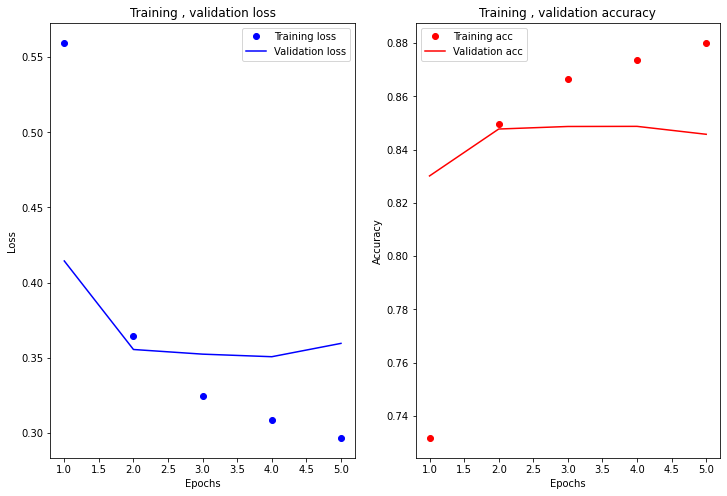

In [17]:
history_rnn_pre_dict = history_rnn_pre.history

acc = history_rnn_pre_dict['accuracy']
val_acc = history_rnn_pre_dict['val_accuracy']
loss = history_rnn_pre_dict['loss']
val_loss = history_rnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training , validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training , validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
results = model_rnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3712 - accuracy: 0.8395
[0.3712218105792999, 0.8395141959190369]


In [19]:
model_1dcnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_pre = model_1dcnn_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 12s 7ms/step - loss: 0.5873 - accuracy: 0.6920 - val_loss: 0.4756 - val_accuracy: 0.7574
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4401 - accuracy: 0.7840 - val_loss: 0.4576 - val_accuracy: 0.7705
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4027 - accuracy: 0.8045 - val_loss: 0.4594 - val_accuracy: 0.7712
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3746 - accuracy: 0.8218 - val_loss: 0.4684 - val_accuracy: 0.7668
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8371 - val_loss: 0.4832 - val_accuracy: 0.7650


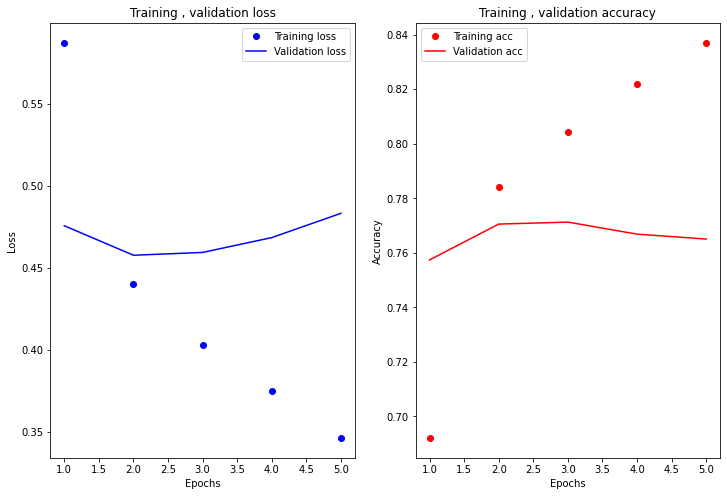

In [20]:
history_1dcnn_pre_dict = history_1dcnn_pre.history

acc = history_1dcnn_pre_dict['accuracy']
val_acc = history_1dcnn_pre_dict['val_accuracy']
loss = history_1dcnn_pre_dict['loss']
val_loss = history_1dcnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training , validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training , validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
results = model_1dcnn_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4886 - accuracy: 0.7604
[0.48860666155815125, 0.7604206800460815]


In [22]:
model_gmp_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_pre = model_gmp_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 1s 4ms/step - loss: 0.6018 - accuracy: 0.7407 - val_loss: 0.4517 - val_accuracy: 0.8203
Epoch 2/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3894 - accuracy: 0.8369 - val_loss: 0.3658 - val_accuracy: 0.8394
Epoch 3/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3318 - accuracy: 0.8602 - val_loss: 0.3518 - val_accuracy: 0.8469
Epoch 4/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3003 - accuracy: 0.8758 - val_loss: 0.3494 - val_accuracy: 0.8485
Epoch 5/5
198/198 [==============================] - 1s 4ms/step - loss: 0.2767 - accuracy: 0.8875 - val_loss: 0.3531 - val_accuracy: 0.8482


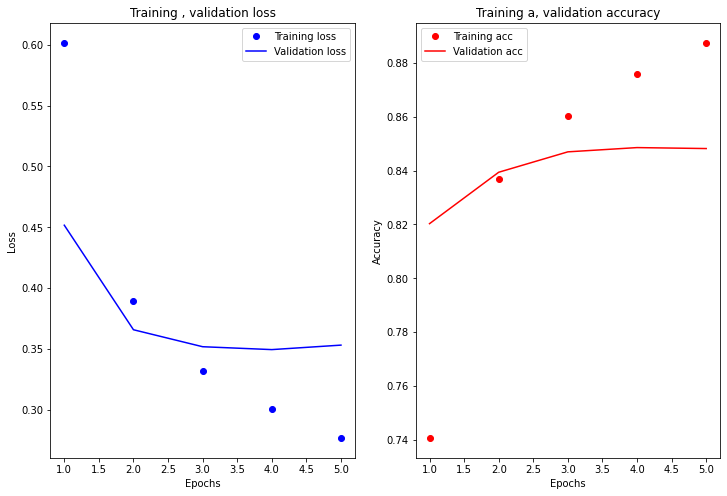

In [23]:
history_gmp_pre_dict = history_gmp_pre.history

acc = history_gmp_pre_dict['accuracy']
val_acc = history_gmp_pre_dict['val_accuracy']
loss = history_gmp_pre_dict['loss']
val_loss = history_gmp_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training , validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training a, validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
results = model_gmp_pre.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3650 - accuracy: 0.8433
[0.3649848699569702, 0.8433183431625366]


### 임베딩 레이어 분석(가장 정확도가 높게나온 RNN모델)

In [25]:
embedding_layer = model_rnn_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

(10000, 16)


In [26]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
vectors.shape 

(10000, 16)

####  워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# Word2Vec 불러오기
word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word2vec.similar_by_word("사랑")

[('귀여움', 0.9785929918289185),
 ('앓', 0.9738229513168335),
 ('괜찮', 0.9716129302978516),
 ('퍼펙트', 0.9703009128570557),
 ('쏠쏠', 0.9702550768852234),
 ('알콩달콩', 0.9701334834098816),
 ('밀리', 0.9696062803268433),
 ('꾀', 0.9679185152053833),
 ('조음', 0.9677662253379822),
 ('레전드', 0.9677280187606812)]

In [29]:
word2vec.similar_by_word("슬픔")

[('리얼리즘', 0.979936957359314),
 ('쿵', 0.9749221801757812),
 ('야호', 0.9745858311653137),
 ('재미있', 0.9741607308387756),
 ('뗄', 0.9729707837104797),
 ('여사', 0.9728869199752808),
 ('사악', 0.9726501703262329),
 ('중독자', 0.9713877439498901),
 ('미남', 0.9711669683456421),
 ('걸작', 0.9708935022354126)]

#### 한국어 word2vec불러오기

In [30]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_133/1005516468.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [31]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_133/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [32]:
word2vec.similar_by_word("슬픔")

/tmp/ipykernel_133/1281145983.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("슬픔")


[('기쁨', 0.7767106294631958),
 ('절망', 0.7710496783256531),
 ('아픔', 0.7430999279022217),
 ('비탄', 0.7297681570053101),
 ('고독', 0.7251476049423218),
 ('사랑', 0.7216662168502808),
 ('외로움', 0.7195188999176025),
 ('추억', 0.6951203346252441),
 ('이별', 0.6873862147331238),
 ('괴로움', 0.6854110956192017)]

In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_133/3778977091.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_133/3778977091.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [34]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.LSTM(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 학습 과정 시각화하기

In [35]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1581/1581 [==============================] - 12s 7ms/step - loss: 0.4052 - accuracy: 0.8132 - val_loss: 0.3360 - val_accuracy: 0.8529
Epoch 2/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.2950 - accuracy: 0.8756 - val_loss: 0.3227 - val_accuracy: 0.8612
Epoch 3/5
1581/1581 [==============================] - 10s 6ms/step - loss: 0.2492 - accuracy: 0.8975 - val_loss: 0.3141 - val_accuracy: 0.8664
Epoch 4/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.2075 - accuracy: 0.9164 - val_loss: 0.3403 - val_accuracy: 0.8626
Epoch 5/5
1581/1581 [==============================] - 10s 7ms/step - loss: 0.1670 - accuracy: 0.9353 - val_loss: 0.3676 - val_accuracy: 0.8635


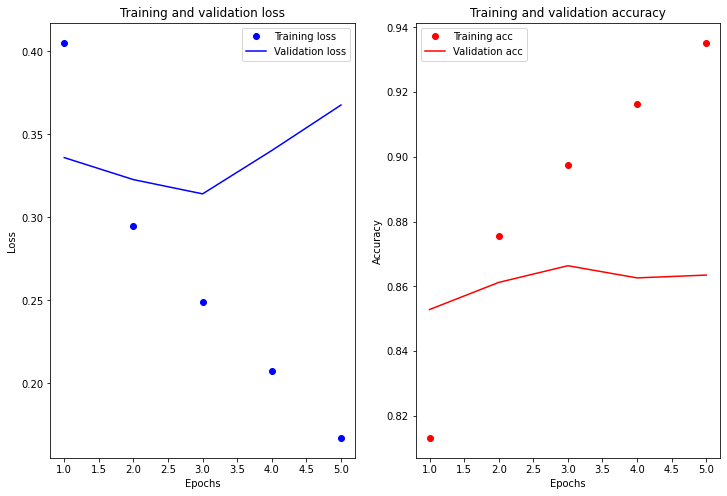

In [36]:
history_ko_dict = history_ko.history

acc = history_ko_dict['accuracy']
val_acc = history_ko_dict['val_accuracy']
loss = history_ko_dict['loss']
val_loss = history_ko_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 정확도 확인하기

In [37]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3749 - accuracy: 0.8583
[0.3748621642589569, 0.858250081539154]


## 회고

#### 이번 프로잭트를 진행하면서 어렸웠던점은 여전히 코드 진행하는것과 코드를 직접 짜는것도 힘들었지만                                                                  한국어 word2vec 파일 찾는것과 버전 낮추는 방법이 찾는게 어려웠던것 같습니다. 방법을 찾으려고 구글링도 해보고 했지만 잘 모르겠어서          다른 분들께 여쭤봤더니 해결방법을 잘 알려주셔서 무사히 해결한거 같습니다. 정말 다음에 또 버전을 낮춰야하는 상황이 오면 절대 안까먹          을수 있을꺼같습니다. 그리고 이번 프로잭트에서는 루브릭 평가기준을 맞추게되서 기분이 좋습니다. 이 기세를 이어서 다음 프로잭트도 루            평가를 달성할수있도록 하겠습니다.!!!